In [1]:
import os
import glob,re
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import tropycal.tracks as tracks
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
# define functions
def load_and_process_file(file_path):
    """Efficiently load and process a single data file"""
    with Dataset(file_path, 'r') as file_model:
        # Load time data and convert to datetime
        time_model = file_model.variables['track_time'][:]
        masked_time = np.ma.masked_invalid(time_model)
        time_model = nc.num2date(masked_time,
                                file_model.variables['track_time'].units,
                                only_use_cftime_datetimes=False,
                                only_use_python_datetimes=True)
        
        # Extract lat/lon data for first position only (more efficient)
        lat_model = file_model.variables['track_lat'][:,0]
        lon_model = file_model.variables['track_lon'][:,0]
    
    # Create years array efficiently
    years = np.array([t[0].year for t in time_model])
    
    # Create DataFrame once with all data
    df = pd.DataFrame({
        'years': years,
        'lat': lat_model,
        'lon': lon_model
    })
    
    # Filter for Western Pacific basin
    mask = (df['lat'].between(5, 60)) & (df['lon'].between(100, 180))
    filtered_df = df[mask]
    
    # Get yearly counts
    return filtered_df['years'].value_counts().sort_index()



def process_all_files(file_pattern):
    """Process all matching files and return combined results"""
    files = glob.glob(file_pattern)
    all_counts = {}
    
    for file in files:
        counts = load_and_process_file(file)
        all_counts[file] = counts
    
    return pd.DataFrame(all_counts)


In [3]:
# When calculating probability distribution:
def calculate_probability_distribution(counts, bins):
    """Calculate probability distribution with improved binning"""
    # Flatten all counts
    all_counts = np.concatenate([counts[col].dropna().values for col in counts.columns])  
    # Calculate histogram and probability
    hist, bin_edges = np.histogram(all_counts, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return bin_centers, hist

In [4]:
def calulate_pdf(data,bins):
# Calculate histogram
    hist, bin_edges = np.histogram(data, bins, density=True)
    
    # Get bin centers for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return bin_centers, hist

In [5]:
file= Dataset('./Dataset/IBTrACS.WP.v04r01.nc', 'r')
print(file.variables.keys())
time = file.variables['time'][:]
d_times=nc.num2date(file.variables['time'][:],file.variables['time'].units
                    ,only_use_cftime_datetimes=False,only_use_python_datetimes=True)
sid=file.variables['sid'][:]
number=file.variables['number'][:]
numobs=file.variables['numobs'][:]
season=file.variables['season'][:]
basins = file.variables['basin'][:]
lat=file.variables['lat'][:]
lon=file.variables['lon'][:]
file.close()

dict_keys(['numobs', 'sid', 'season', 'number', 'basin', 'subbasin', 'name', 'source_usa', 'source_jma', 'source_cma', 'source_hko', 'source_kma', 'source_new', 'source_reu', 'source_bom', 'source_nad', 'source_wel', 'source_td5', 'source_td6', 'source_ds8', 'source_neu', 'source_mlc', 'time', 'iso_time', 'nature', 'lat', 'lon', 'wmo_wind', 'wmo_pres', 'wmo_agency', 'track_type', 'main_track_sid', 'dist2land', 'landfall', 'iflag', 'usa_agency', 'usa_atcf_id', 'usa_lat', 'usa_lon', 'usa_record', 'usa_status', 'usa_wind', 'usa_pres', 'usa_sshs', 'usa_r34', 'usa_r50', 'usa_r64', 'usa_poci', 'usa_roci', 'usa_rmw', 'usa_eye', 'tokyo_lat', 'tokyo_lon', 'tokyo_grade', 'tokyo_wind', 'tokyo_pres', 'tokyo_r50_dir', 'tokyo_r50_long', 'tokyo_r50_short', 'tokyo_r30_dir', 'tokyo_r30_long', 'tokyo_r30_short', 'tokyo_land', 'cma_lat', 'cma_lon', 'cma_cat', 'cma_wind', 'cma_pres', 'hko_lat', 'hko_lon', 'hko_cat', 'hko_wind', 'hko_pres', 'kma_lat', 'kma_lon', 'kma_cat', 'kma_wind', 'kma_pres', 'kma_r50_

Western Pacific (WP) locations: 5–60°N 100°–180°E

In [6]:
years=[]
for i in range (len(d_times)):
    years.append(d_times[i][0].year)

In [7]:
years_count_obs=pd.Series(years).value_counts().sort_index()

In [8]:
years_count_obs

1884    14
1885     9
1886    15
1887    21
1888    13
        ..
2020    28
2021    29
2022    31
2023    20
2024    12
Name: count, Length: 141, dtype: int64

In [9]:
bins_obs, prob_obs = calulate_pdf(years_count_obs,10)

Text(39.07006401909722, 0.5, 'Relative Probability')

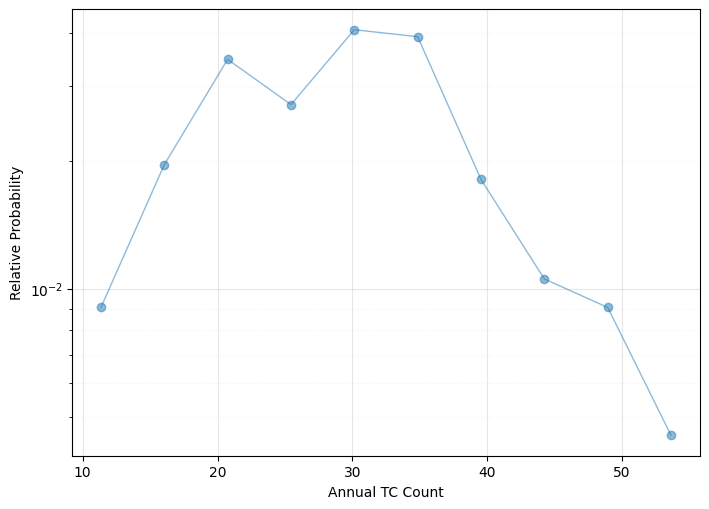

In [10]:
plt.figure(figsize=(7, 5))
plt.semilogy(bins_obs, prob_obs, '-o', alpha=0.5, linewidth=1) 
# Configure grid
plt.grid(True, which='major', linestyle='-', alpha=0.3)
plt.grid(True, which='minor', linestyle=':', alpha=0.15)
plt.tight_layout()
plt.xlabel('Annual TC Count')
plt.ylabel('Relative Probability')

In [11]:
file_model=Dataset('./Dataset/d4PDF_tropical_cyclone/MRI_HPB_m001.nc','r')
print(file_model.variables.keys())
time_model=file_model.variables['track_time'][:]
masked_time=np.ma.masked_invalid(time_model)
time_model=nc.num2date(masked_time,file_model.variables['track_time'].units 
                    ,only_use_cftime_datetimes=False,only_use_python_datetimes=True)
lat_model=file_model.variables['track_lat'][:]
lon_model=file_model.variables['track_lon'][:]
file_model.close()

dict_keys(['track_time', 'track_lat', 'track_lon', 'track_pres', 'track_wind'])


In [12]:
years_model=[]
for i in range (len(time_model)):
    years_model.append(time_model[i][0].year)

In [13]:
# filter the data in WP basin, 5-60N, 100-180E
df = pd.DataFrame({
    'years': np.array(years_model),
    'lat': lat_model[:,0],
    'lon': lon_model[:,0]
})

In [14]:
filtered_df = df[
    (df['lat'].between(5, 60)) & 
    (df['lon'].between(100, 180))
]

In [15]:
filtered_df

,years,lat,lon
2,1951,5.34,105.75
4,1951,5.91,131.06
7,1951,9.28,114.75
23,1951,16.03,118.69
24,1951,12.66,132.75
...,...,...,...
5146,2011,10.41,151.31
5151,2011,9.28,146.81
5162,2011,5.91,126.00
5163,2011,8.16,121.50


In [16]:
years_count_current1 = filtered_df['years'].value_counts().sort_index()

In [17]:
years_count_current1

years
1951    30
1952    29
1953    17
1954    31
1955    35
        ..
2007    27
2008    15
2009    22
2010    18
2011    24
Name: count, Length: 61, dtype: int64

In [18]:
bins_current1, prob_current1 = calulate_pdf(years_count_current1,10)

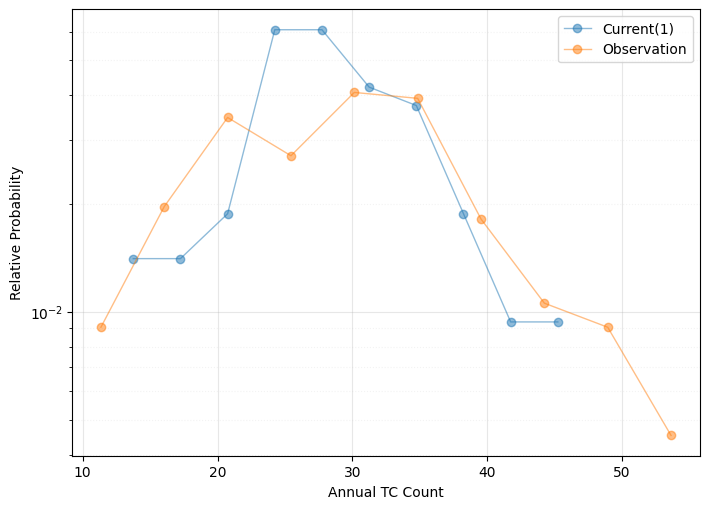

In [19]:
plt.figure(figsize=(7, 5))
plt.semilogy(bins_current1, prob_current1, '-o', alpha=0.5, linewidth=1, label='Current(1)')
plt.semilogy(bins_obs, prob_obs, '-o', alpha=0.5, linewidth=1, label='Observation')
# Configure grid
plt.grid(True, which='major', linestyle='-', alpha=0.3)
plt.grid(True, which='minor', linestyle=':', alpha=0.15)
plt.tight_layout()
plt.xlabel('Annual TC Count')
plt.ylabel('Relative Probability')
plt.legend()

In [20]:
all_data_current = process_all_files('./Dataset/d4PDF_tropical_cyclone/MRI_HPB_m[0-9][0-9][0-9].nc')

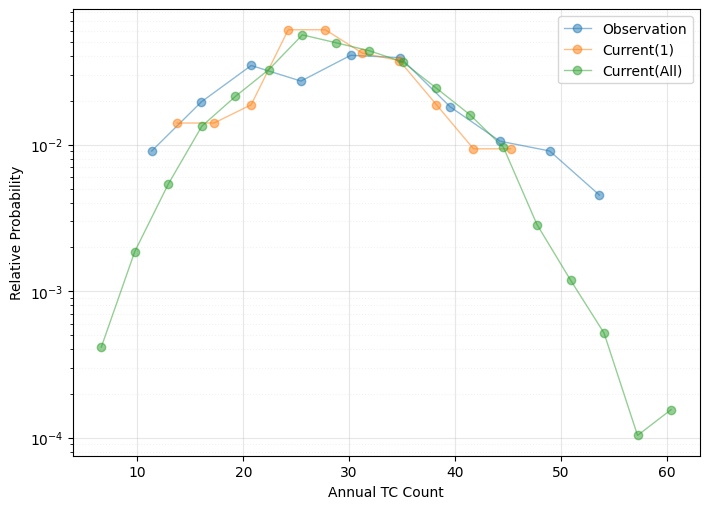

In [21]:
bins_current_all, prob_current_all = calculate_probability_distribution(all_data_current,18)

plt.figure(figsize=(7, 5))
plt.semilogy(bins_obs, prob_obs, '-o', alpha=0.5, linewidth=1, label='Observation')
plt.semilogy(bins_current1, prob_current1, '-o', alpha=0.5, linewidth=1, label='Current(1)')
plt.semilogy(bins_current_all, prob_current_all, '-o', alpha=0.5, linewidth=1, label='Current(All)')
# Configure grid
plt.grid(True, which='major', linestyle='-', alpha=0.3)
plt.grid(True, which='minor', linestyle=':', alpha=0.15)
plt.tight_layout()
plt.xlabel('Annual TC Count')
plt.ylabel('Relative Probability')
plt.legend()

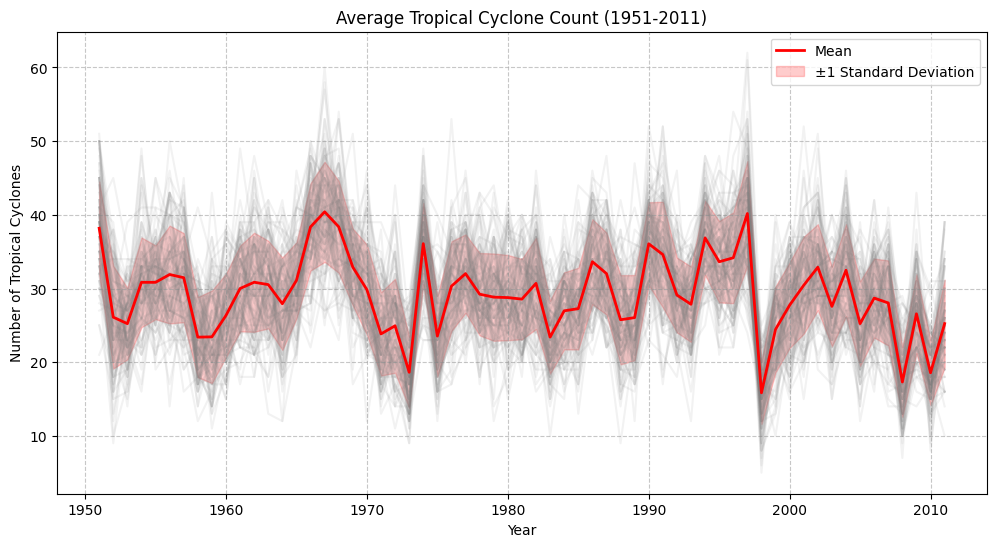

Average number of cyclones per year: 29.22
Standard deviation: 5.30
Maximum yearly average: 40.41 (1967)
Minimum yearly average: 15.84 (1998)


In [22]:
# Calculate average curve and standard deviation
mean_curve = all_data_current.mean(axis=1)
std_curve = all_data_current.std(axis=1)

# Plotting
plt.figure(figsize=(12, 6))

# Plot individual curves with low opacity if desired
for curve in all_data_current.values.T:
    plt.plot(all_data_current.index, curve, 'gray', alpha=0.1)

# Plot mean curve with confidence interval
plt.plot(mean_curve.index, mean_curve.values, 'r-', linewidth=2, label='Mean')
plt.fill_between(mean_curve.index, 
                 mean_curve.values - std_curve.values,
                 mean_curve.values + std_curve.values,
                 color='r', alpha=0.2, label='±1 Standard Deviation')

plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Number of Tropical Cyclones')
plt.title('Average Tropical Cyclone Count (1951-2011)')
plt.legend()

# Optional: Add y-axis scaling if needed
#plt.yscale('log')  # If you want logarithmic scale

plt.show()

# Print some statistics
print(f"Average number of cyclones per year: {mean_curve.mean():.2f}")
print(f"Standard deviation: {mean_curve.std():.2f}")
print(f"Maximum yearly average: {mean_curve.max():.2f} ({mean_curve.idxmax()})")
print(f"Minimum yearly average: {mean_curve.min():.2f} ({mean_curve.idxmin()})")